In [ ]:
import os
import random
import yaml
import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn
from ultralytics import YOLO
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def get_image_files(folder):
    """Возвращает список файлов изображений (jpg/png и т.п.) из указанной папки."""
    return [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

train_images_folder = "train/images"
valid_images_folder = "valid/images"

train_images = get_image_files(train_images_folder)
valid_images = get_image_files(valid_images_folder)

all_images = []
for img in train_images:
    all_images.append(os.path.join(train_images_folder, img))
for img in valid_images:
    all_images.append(os.path.join(valid_images_folder, img))

print("Всего изображений (train + valid):", len(all_images))

random.shuffle(all_images)

# Разбиваем на k фолдов
k_folds = 5
fold_size = len(all_images) // k_folds
folds = []
for i in range(k_folds):
    start = i * fold_size
    end = start + fold_size
    if i == k_folds - 1:  # последний фолд берёт всё, что осталось
        end = len(all_images)
    folds.append(all_images[start:end])

def create_data_files_for_fold(fold_idx, folds, base_data_yaml="data.yaml"):
    """
    - Создаёт fold_{i}/train.txt и fold_{i}/val.txt с путями к изображениям
    - Создаёт fold_{i}/data_fold_{i}.yaml, где train=ABS_PATH(train.txt), val=ABS_PATH(val.txt)
    Возвращает (абсолютный) путь к созданному data_fold_{i}.yaml
    """
    fold_dir = f"fold_{fold_idx}"
    os.makedirs(fold_dir, exist_ok=True)

    # Текущий фолд - валидация
    val_images = folds[fold_idx]
    # Остальные фолды - тренировка
    train_images = []
    for j in range(k_folds):
        if j != fold_idx:
            train_images.extend(folds[j])

    train_txt_rel = os.path.join(fold_dir, "train.txt")
    val_txt_rel   = os.path.join(fold_dir, "val.txt")

    with open(train_txt_rel, "w") as f:
        for path in train_images:
            f.write(path + "\n")

    with open(val_txt_rel, "w") as f:
        for path in val_images:
            f.write(path + "\n")

    train_txt_abs = os.path.abspath(train_txt_rel)
    val_txt_abs   = os.path.abspath(val_txt_rel)

    with open(base_data_yaml, "r") as f:
        data = yaml.safe_load(f)

    data["train"] = train_txt_abs
    data["val"]   = val_txt_abs

    fold_data_yaml_rel = os.path.join(fold_dir, f"data_fold_{fold_idx}.yaml")
    with open(fold_data_yaml_rel, "w") as f:
        yaml.dump(data, f, default_flow_style=False)

    return os.path.abspath(fold_data_yaml_rel)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Всего изображений (train + valid): 4320
Device: cuda


In [ ]:
base_model = "yolov9s.pt"
num_epochs = 25

all_results = []

for fold_idx in range(k_folds):
    print(f"\n=== Обучение на фолде {fold_idx+1} из {k_folds} ===")
    
    fold_data_yaml_abs = create_data_files_for_fold(fold_idx, folds, base_data_yaml="data.yaml")
    
    model = YOLO(base_model)

    model.train(
        data=fold_data_yaml_abs,
        epochs=num_epochs,
        imgsz=416,
        optimizer='AdamW',
        lr0=1e-3,
        project='YOLO9s_fold',
        name=f'fold_{fold_idx}',
        batch=32,
        device=device,
        seed=SEED 
    )

    results_csv_path = os.path.join('YOLO9s_fold', f'fold_{fold_idx}', 'results.csv')
    if os.path.exists(results_csv_path):
        df_results = pd.read_csv(results_csv_path)
        df_results["fold"] = fold_idx
        all_results.append(df_results)
    else:
        print(f"Файл {results_csv_path} не найден. Проверьте, что обучение для fold_{fold_idx} завершилось корректно.")


=== Обучение на фолде 1 из 5 ===
New https://pypi.org/project/ultralytics/8.3.75 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/home/user/CourseWork/Disease/fold_0/data_fold_0.yaml, epochs=25, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=YOLO9s_fold, name=fold_0, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_n

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     31104  ultralytics.nn.modules.block.ELAN1           [64, 64, 64, 32]              
  3                  -1  1     73984  ultralytics.nn.modules.block.AConv           [64, 128]                     
  4                  -1  1    258432  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 128, 128, 64, 3]        
  5                  -1  1    221568  ultralytics.nn.modules.block.AConv           [128, 192]                    
  6                  -1  1    579648  ultralytics.nn.modules.block.RepNCSPELAN4    [192, 192, 192, 96, 3]        
  7                  -1  1    442880  ultralytic

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1686.95it/s]

train: New cache created: train/labels.cache



val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1669.11it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO9s_fold/fold_0/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO9s_fold/fold_0
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.39G      1.135      2.089      1.446        134        416: 100%|██████████| 108/108 [00:27<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        864       1930      0.525      0.356       0.42      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.39G      1.126      1.434      1.419        171        416: 100%|██████████| 108/108 [00:23<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]

                   all        864       1930      0.534      0.655       0.62      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.39G      1.052      1.279      1.364        142        416: 100%|██████████| 108/108 [00:22<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]


                   all        864       1930      0.687      0.608      0.678      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.39G       1.06       1.24      1.373        134        416: 100%|██████████| 108/108 [00:22<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1930       0.59       0.57      0.575      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.34G      1.034      1.169      1.354        134        416: 100%|██████████| 108/108 [00:22<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1930      0.649      0.747      0.722      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.39G     0.9895      1.058      1.327        130        416: 100%|██████████| 108/108 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all        864       1930      0.771      0.726      0.779      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.39G     0.9589      1.006      1.314        126        416: 100%|██████████| 108/108 [00:22<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]


                   all        864       1930      0.803      0.723      0.779      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       4.4G     0.9477     0.9769      1.302        136        416: 100%|██████████| 108/108 [00:22<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1930      0.741      0.776      0.799        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.39G     0.9152      0.938      1.285        156        416: 100%|██████████| 108/108 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1930      0.802      0.781      0.826      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.34G     0.8948      0.907      1.269        129        416: 100%|██████████| 108/108 [00:22<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1930      0.807      0.783      0.848      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.39G     0.8749     0.8701      1.253        130        416: 100%|██████████| 108/108 [00:22<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]


                   all        864       1930      0.819      0.789      0.859      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.39G     0.8636     0.8188      1.246        132        416: 100%|██████████| 108/108 [00:22<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1930       0.85      0.816      0.873      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.38G     0.8708     0.8011      1.249        155        416: 100%|██████████| 108/108 [00:22<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        864       1930      0.796       0.82       0.85      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.39G      0.836     0.7824      1.228        138        416: 100%|██████████| 108/108 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


                   all        864       1930      0.828      0.812      0.864      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.39G     0.8217     0.7673      1.219        111        416: 100%|██████████| 108/108 [00:22<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1930      0.823      0.829       0.88      0.696


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.38G     0.7304     0.6543        1.2         67        416: 100%|██████████| 108/108 [00:22<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1930      0.844      0.845      0.885        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.37G      0.707     0.6291      1.185         45        416: 100%|██████████| 108/108 [00:22<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

                   all        864       1930      0.841      0.831      0.866      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.37G     0.7014     0.5953      1.183         68        416: 100%|██████████| 108/108 [00:22<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1930      0.858      0.828      0.886      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.38G     0.6788     0.5651      1.166         65        416: 100%|██████████| 108/108 [00:22<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1930      0.886      0.841      0.908       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.38G     0.6642     0.5335      1.153         56        416: 100%|██████████| 108/108 [00:22<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        864       1930      0.852      0.857      0.898      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.37G     0.6515     0.5271      1.142         77        416: 100%|██████████| 108/108 [00:22<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

                   all        864       1930      0.888      0.866      0.914      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.39G     0.6327     0.4967      1.126         73        416: 100%|██████████| 108/108 [00:22<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]

                   all        864       1930      0.881      0.874       0.92      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.39G      0.615     0.4658       1.12         60        416: 100%|██████████| 108/108 [00:22<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

                   all        864       1930      0.899      0.874      0.924      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.37G     0.6024     0.4576      1.103         72        416: 100%|██████████| 108/108 [00:21<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

                   all        864       1930      0.888      0.899       0.93       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.38G     0.5915     0.4355      1.092         50        416: 100%|██████████| 108/108 [00:22<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

                   all        864       1930      0.916      0.875      0.929      0.777



25 epochs completed in 0.193 hours.
Optimizer stripped from YOLO9s_fold/fold_0/weights/last.pt, 15.2MB
Optimizer stripped from YOLO9s_fold/fold_0/weights/best.pt, 15.2MB

Validating YOLO9s_fold/fold_0/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv9s summary (fused): 486 layers, 7,171,732 parameters, 0 gradients, 26.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.15it/s]


                   all        864       1930      0.914      0.876      0.929      0.777
Beans_Angular_LeafSpot         59        208      0.806      0.745      0.797      0.536
            Beans_Rust         92        448      0.846      0.781      0.892       0.69
Strawberry_Angular_LeafSpot         70         87      0.976      0.919      0.975       0.81
Strawberry_Anthracnose_Fruit_Rot         31         41      0.923      0.732      0.886      0.612
Strawberry_Blossom_Blight         53         83      0.909          1      0.987      0.885
  Strawberry_Gray_Mold         69         77      0.915      0.896       0.94       0.66
  Strawberry_Leaf_Spot         88        365      0.948      0.902      0.965      0.885
Strawberry_Powdery_Mildew_Fruit         38         89      0.936      0.865      0.937      0.777
Strawberry_Powdery_Mildew_Leaf         69        232      0.803      0.754      0.843      0.723
         Tomato_Blight         86         87      0.941      0.977      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1157.25it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1536.88it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO9s_fold/fold_1/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO9s_fold/fold_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.42G      1.139      2.115      1.457        135        416: 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]


                   all        864       1884     0.0946      0.628      0.201      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       4.4G      1.104      1.448      1.415        176        416: 100%|██████████| 108/108 [00:24<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]


                   all        864       1884      0.699      0.602      0.663      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       4.4G      1.058      1.284      1.374        117        416: 100%|██████████| 108/108 [00:22<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1884      0.547      0.539      0.553      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.39G      1.064      1.251      1.378        134        416: 100%|██████████| 108/108 [00:22<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1884      0.653      0.632      0.659       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.34G      1.041      1.165      1.365        127        416: 100%|██████████| 108/108 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]


                   all        864       1884      0.734      0.716      0.755      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       4.4G     0.9841      1.058      1.336        123        416: 100%|██████████| 108/108 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

                   all        864       1884      0.775       0.76      0.811      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.34G     0.9566      1.003      1.312        113        416: 100%|██████████| 108/108 [00:22<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1884      0.748      0.732      0.779      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.39G     0.9486     0.9734      1.306        132        416: 100%|██████████| 108/108 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1884      0.821      0.767      0.853      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.34G     0.9179     0.9434      1.286        122        416: 100%|██████████| 108/108 [00:22<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1884      0.815      0.791      0.869      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.37G      0.907     0.8989      1.276        148        416: 100%|██████████| 108/108 [00:22<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1884      0.836      0.775      0.854      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.39G     0.8771     0.8666      1.253        158        416: 100%|██████████| 108/108 [00:22<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1884      0.849      0.825      0.884       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.39G      0.862     0.8314      1.242        126        416: 100%|██████████| 108/108 [00:22<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1884       0.83      0.833      0.879      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.39G     0.8496     0.7998      1.237        117        416: 100%|██████████| 108/108 [00:22<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        864       1884      0.862      0.819      0.884      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.39G     0.8377      0.788      1.231        129        416: 100%|██████████| 108/108 [00:22<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1884       0.85      0.834      0.887      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.39G     0.8204      0.763       1.22        122        416: 100%|██████████| 108/108 [00:22<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1884      0.864       0.84      0.905      0.727


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.37G     0.7279     0.6708      1.201         60        416: 100%|██████████| 108/108 [00:23<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

                   all        864       1884      0.822       0.83      0.879      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.37G     0.7183     0.6279      1.196         49        416: 100%|██████████| 108/108 [00:22<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all        864       1884      0.876      0.838      0.904      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.37G     0.6939     0.5903      1.177         75        416: 100%|██████████| 108/108 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1884      0.894      0.865      0.928      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.38G     0.6757     0.5715      1.159         64        416: 100%|██████████| 108/108 [00:22<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]

                   all        864       1884      0.891      0.866      0.926      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.37G     0.6659     0.5423      1.146         62        416: 100%|██████████| 108/108 [00:22<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

                   all        864       1884      0.883      0.872      0.925      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.37G     0.6551     0.5173      1.143         69        416: 100%|██████████| 108/108 [00:22<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1884      0.912      0.879      0.935      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.38G     0.6312     0.4892      1.125         67        416: 100%|██████████| 108/108 [00:22<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1884      0.871        0.9      0.932      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.38G     0.6153     0.4731      1.114         60        416: 100%|██████████| 108/108 [00:22<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1884      0.895      0.902      0.937       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.37G     0.6061     0.4553      1.105         67        416: 100%|██████████| 108/108 [00:22<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

                   all        864       1884      0.897      0.896      0.934      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.37G     0.5921       0.44      1.088         64        416: 100%|██████████| 108/108 [00:22<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1884       0.91      0.895      0.942      0.799



25 epochs completed in 0.194 hours.
Optimizer stripped from YOLO9s_fold/fold_1/weights/last.pt, 15.2MB
Optimizer stripped from YOLO9s_fold/fold_1/weights/best.pt, 15.2MB

Validating YOLO9s_fold/fold_1/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv9s summary (fused): 486 layers, 7,171,732 parameters, 0 gradients, 26.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.14it/s]


                   all        864       1884      0.909      0.896      0.942      0.799
Beans_Angular_LeafSpot         88        280      0.873      0.762      0.861      0.584
            Beans_Rust         81        410      0.866      0.824      0.916      0.704
Strawberry_Angular_LeafSpot         69         89      0.909      0.933      0.961      0.834
Strawberry_Anthracnose_Fruit_Rot         26         45      0.822      0.667      0.813      0.586
Strawberry_Blossom_Blight         51         74      0.984          1      0.995      0.872
  Strawberry_Gray_Mold         83         86      0.932      0.958      0.981      0.745
  Strawberry_Leaf_Spot         90        330      0.924      0.888       0.96      0.892
Strawberry_Powdery_Mildew_Fruit         46        101      0.882      0.871      0.951      0.801
Strawberry_Powdery_Mildew_Leaf         68        206      0.762      0.874      0.894      0.764
         Tomato_Blight         86         87      0.986      0.989      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1489.40it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1571.42it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO9s_fold/fold_2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO9s_fold/fold_2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.42G      1.149      2.101      1.467        125        416: 100%|██████████| 108/108 [00:26<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]


                   all        864       1795      0.453       0.39      0.402      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.39G      1.106      1.426      1.407        168        416: 100%|██████████| 108/108 [00:24<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]

                   all        864       1795       0.55       0.65      0.627      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.35G      1.056      1.243       1.37        145        416: 100%|██████████| 108/108 [00:23<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

                   all        864       1795      0.678      0.519      0.603      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.35G      1.063      1.227      1.376        128        416: 100%|██████████| 108/108 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]

                   all        864       1795      0.649      0.718      0.728      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       4.4G       1.04      1.167      1.357        127        416: 100%|██████████| 108/108 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]

                   all        864       1795      0.717       0.74      0.776      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       4.4G      1.005      1.068      1.342        140        416: 100%|██████████| 108/108 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.20it/s]

                   all        864       1795       0.74      0.741      0.807      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.39G     0.9707     0.9939       1.32        113        416: 100%|██████████| 108/108 [00:22<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        864       1795      0.764      0.754      0.813      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.37G     0.9661      1.014      1.313        127        416: 100%|██████████| 108/108 [00:22<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1795      0.772      0.774      0.828      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.39G     0.9327     0.9396      1.291        143        416: 100%|██████████| 108/108 [00:22<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.20it/s]


                   all        864       1795      0.795      0.771      0.824       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.39G      0.912     0.9079      1.278        131        416: 100%|██████████| 108/108 [00:22<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1795      0.843      0.812       0.87      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       4.4G     0.8854      0.874      1.264        153        416: 100%|██████████| 108/108 [00:22<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

                   all        864       1795      0.826      0.815       0.88      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.38G     0.8654     0.8449      1.254        137        416: 100%|██████████| 108/108 [00:22<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all        864       1795       0.85      0.839      0.892      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.39G     0.8613     0.8253      1.245        147        416: 100%|██████████| 108/108 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        864       1795      0.859      0.839      0.894      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.39G     0.8412     0.7872      1.226        124        416: 100%|██████████| 108/108 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1795      0.851      0.819      0.888      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       4.4G     0.8283      0.758      1.223        118        416: 100%|██████████| 108/108 [00:22<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1795       0.88      0.847      0.904      0.731


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       4.4G     0.7332     0.6686       1.21         61        416: 100%|██████████| 108/108 [00:24<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1795      0.867      0.813      0.887      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.38G     0.7235     0.6326      1.195         53        416: 100%|██████████| 108/108 [00:23<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1795      0.848      0.846        0.9      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.39G     0.6964      0.596      1.178         76        416: 100%|██████████| 108/108 [00:22<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1795      0.856      0.866      0.904      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.37G     0.6804     0.5603      1.165         58        416: 100%|██████████| 108/108 [00:22<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        864       1795      0.897      0.884      0.927      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.39G     0.6542     0.5303      1.144         46        416: 100%|██████████| 108/108 [00:23<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

                   all        864       1795      0.913      0.859      0.929      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.38G      0.651     0.5163      1.137         88        416: 100%|██████████| 108/108 [00:23<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1795        0.9      0.884      0.933      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.39G     0.6317     0.4939      1.125         70        416: 100%|██████████| 108/108 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1795      0.901      0.884      0.941      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.38G     0.6215     0.4772      1.122         55        416: 100%|██████████| 108/108 [00:23<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1795      0.883      0.902      0.937      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.39G     0.6112     0.4571      1.105         81        416: 100%|██████████| 108/108 [00:22<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1795      0.896      0.899      0.944      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.39G     0.5991     0.4434      1.092         61        416: 100%|██████████| 108/108 [00:22<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]

                   all        864       1795      0.892      0.914      0.948      0.809



25 epochs completed in 0.197 hours.
Optimizer stripped from YOLO9s_fold/fold_2/weights/last.pt, 15.2MB
Optimizer stripped from YOLO9s_fold/fold_2/weights/best.pt, 15.2MB

Validating YOLO9s_fold/fold_2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv9s summary (fused): 486 layers, 7,171,732 parameters, 0 gradients, 26.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.08it/s]


                   all        864       1795      0.894      0.913      0.948      0.809
Beans_Angular_LeafSpot         71        235      0.838      0.815      0.871       0.57
            Beans_Rust         83        383      0.829      0.849      0.918      0.719
Strawberry_Angular_LeafSpot         69         84      0.949      0.892      0.942      0.822
Strawberry_Anthracnose_Fruit_Rot         28         45      0.931      0.895      0.974      0.729
Strawberry_Blossom_Blight         72        102      0.935      0.989      0.994      0.883
  Strawberry_Gray_Mold         91         98      0.947      0.888      0.945       0.71
  Strawberry_Leaf_Spot         86        273       0.88      0.952       0.98      0.931
Strawberry_Powdery_Mildew_Fruit         35         75      0.747        0.8       0.87      0.681
Strawberry_Powdery_Mildew_Leaf         77        245       0.73      0.902      0.902      0.806
         Tomato_Blight         82         82      0.969      0.988      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1300.33it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1629.29it/s]


val: New cache created: train/labels.cache
Plotting labels to YOLO9s_fold/fold_3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO9s_fold/fold_3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.42G      1.145        2.1      1.465        138        416: 100%|██████████| 108/108 [00:26<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]


                   all        864       1994      0.345      0.342      0.272      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       4.4G      1.107      1.408      1.403        158        416: 100%|██████████| 108/108 [00:24<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.20it/s]


                   all        864       1994      0.643      0.653      0.691      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.39G       1.05      1.238      1.365        142        416: 100%|██████████| 108/108 [00:22<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]


                   all        864       1994      0.617      0.518      0.545      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.38G       1.06      1.242      1.372        120        416: 100%|██████████| 108/108 [00:22<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]


                   all        864       1994      0.705      0.694      0.746      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.37G      1.024      1.161      1.353        131        416: 100%|██████████| 108/108 [00:22<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        864       1994      0.697      0.742      0.802       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.39G     0.9854      1.062      1.326        127        416: 100%|██████████| 108/108 [00:22<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1994       0.77      0.745      0.799      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.39G     0.9624      1.026      1.315        124        416: 100%|██████████| 108/108 [00:22<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        864       1994      0.811      0.759       0.82      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.39G     0.9485     0.9809      1.302        128        416: 100%|██████████| 108/108 [00:22<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1994      0.778      0.783      0.831      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.38G      0.926     0.9346      1.285        143        416: 100%|██████████| 108/108 [00:22<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        864       1994      0.819      0.814      0.862      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.39G     0.9028     0.8971      1.273        156        416: 100%|██████████| 108/108 [00:22<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.26it/s]

                   all        864       1994      0.831      0.795      0.839      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       4.4G     0.8864     0.8782      1.259        129        416: 100%|██████████| 108/108 [00:22<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

                   all        864       1994      0.816      0.811      0.861      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.34G     0.8622     0.8228      1.244        134        416: 100%|██████████| 108/108 [00:22<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1994      0.839      0.815      0.871      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       4.4G     0.8543     0.8115      1.239        124        416: 100%|██████████| 108/108 [00:22<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

                   all        864       1994      0.844      0.848      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.37G     0.8343     0.7872      1.225        144        416: 100%|██████████| 108/108 [00:22<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

                   all        864       1994      0.858      0.851      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.39G     0.8143     0.7649      1.216        123        416: 100%|██████████| 108/108 [00:22<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]

                   all        864       1994      0.835      0.857      0.894      0.724


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.38G       0.74     0.6556        1.2         65        416: 100%|██████████| 108/108 [00:24<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]

                   all        864       1994      0.857       0.86      0.896      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.38G     0.7124     0.6255      1.184         60        416: 100%|██████████| 108/108 [00:23<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        864       1994      0.885      0.843      0.902      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.39G     0.6916     0.5943      1.175         58        416: 100%|██████████| 108/108 [00:22<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1994       0.87      0.865      0.903      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.37G      0.674     0.5653      1.159         71        416: 100%|██████████| 108/108 [00:22<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

                   all        864       1994      0.887      0.866      0.905      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.38G     0.6529     0.5291      1.138         61        416: 100%|██████████| 108/108 [00:22<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        864       1994      0.873      0.864      0.907      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.37G     0.6486     0.5164      1.134         72        416: 100%|██████████| 108/108 [00:22<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

                   all        864       1994      0.906      0.858      0.912      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.39G     0.6306     0.4867      1.123         72        416: 100%|██████████| 108/108 [00:22<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1994      0.882      0.888      0.921       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.37G     0.6144     0.4694      1.116         60        416: 100%|██████████| 108/108 [00:23<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1994      0.899       0.89      0.922      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.38G     0.5979      0.451      1.094         55        416: 100%|██████████| 108/108 [00:22<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1994       0.89      0.885      0.921      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.37G     0.5889      0.427      1.086         63        416: 100%|██████████| 108/108 [00:22<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1994      0.895      0.889      0.924      0.783



25 epochs completed in 0.195 hours.
Optimizer stripped from YOLO9s_fold/fold_3/weights/last.pt, 15.2MB
Optimizer stripped from YOLO9s_fold/fold_3/weights/best.pt, 15.2MB

Validating YOLO9s_fold/fold_3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv9s summary (fused): 486 layers, 7,171,732 parameters, 0 gradients, 26.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


                   all        864       1994      0.894      0.889      0.924      0.782
Beans_Angular_LeafSpot         78        272      0.793      0.734      0.749      0.494
            Beans_Rust         91        476      0.872      0.805      0.898      0.695
Strawberry_Angular_LeafSpot         66         75      0.973      0.968      0.991      0.876
Strawberry_Anthracnose_Fruit_Rot         34         59      0.792      0.708      0.789      0.525
Strawberry_Blossom_Blight         58         83      0.927      0.988      0.992      0.869
  Strawberry_Gray_Mold         67         68       0.89      0.912      0.925      0.713
  Strawberry_Leaf_Spot         91        335      0.917      0.934      0.974      0.902
Strawberry_Powdery_Mildew_Fruit         42         85      0.877      0.838      0.948      0.767
Strawberry_Powdery_Mildew_Leaf         78        280      0.738      0.789      0.843      0.724
         Tomato_Blight         93         93      0.964          1      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:03<00:00, 1125.44it/s]

train: New cache created: train/labels.cache



val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1637.72it/s]


val: New cache created: train/labels.cache
Plotting labels to YOLO9s_fold/fold_4/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO9s_fold/fold_4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.42G      1.144      2.116      1.467        124        416: 100%|██████████| 108/108 [00:26<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


                   all        864       1886      0.368      0.565      0.467      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       4.4G      1.103      1.462      1.413        171        416: 100%|██████████| 108/108 [00:24<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


                   all        864       1886      0.578      0.681      0.647      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       4.4G      1.049      1.261      1.374        134        416: 100%|██████████| 108/108 [00:22<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]


                   all        864       1886      0.503      0.644      0.625      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.39G      1.071      1.224      1.384        139        416: 100%|██████████| 108/108 [00:23<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1886      0.661      0.637      0.694      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.39G       1.03      1.177      1.361        131        416: 100%|██████████| 108/108 [00:22<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        864       1886      0.734      0.732      0.757       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.39G     0.9879      1.075      1.337        133        416: 100%|██████████| 108/108 [00:22<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1886       0.76      0.736      0.798      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.39G     0.9678      1.029      1.326        118        416: 100%|██████████| 108/108 [00:22<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all        864       1886      0.821      0.773      0.833      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       4.4G      0.936     0.9563      1.301        115        416: 100%|██████████| 108/108 [00:22<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        864       1886      0.777      0.766      0.806       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.38G     0.9217     0.9597      1.298        154        416: 100%|██████████| 108/108 [00:22<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1886      0.796      0.763      0.833      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.35G     0.8983       0.91      1.275        142        416: 100%|██████████| 108/108 [00:22<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1886      0.844      0.791      0.875       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       4.4G     0.8856      0.865      1.268        150        416: 100%|██████████| 108/108 [00:22<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1886      0.829      0.825      0.869      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.38G     0.8715     0.8415      1.247        131        416: 100%|██████████| 108/108 [00:23<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        864       1886      0.826      0.828      0.872      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       4.4G     0.8516     0.8068       1.24        133        416: 100%|██████████| 108/108 [00:22<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1886      0.846      0.823      0.885      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.39G     0.8334      0.788      1.223        127        416: 100%|██████████| 108/108 [00:22<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1886      0.843      0.823      0.882      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.39G     0.8303     0.7687      1.221        132        416: 100%|██████████| 108/108 [00:22<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1886      0.851      0.841      0.889      0.717


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.39G     0.7307      0.646      1.203         71        416: 100%|██████████| 108/108 [00:24<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]

                   all        864       1886      0.861      0.829      0.901      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.39G      0.718     0.6352      1.192         55        416: 100%|██████████| 108/108 [00:23<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]

                   all        864       1886       0.85      0.842      0.899      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.39G     0.6838     0.5796      1.172         63        416: 100%|██████████| 108/108 [00:23<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]

                   all        864       1886      0.884      0.857      0.915      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.35G     0.6804     0.5575      1.162         60        416: 100%|██████████| 108/108 [00:23<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1886      0.854       0.89      0.919      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.35G     0.6552     0.5367      1.142         57        416: 100%|██████████| 108/108 [00:23<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1886       0.86      0.855      0.904      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.39G      0.646     0.5283      1.133         75        416: 100%|██████████| 108/108 [00:23<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1886      0.881      0.877      0.923      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.38G     0.6317     0.4985      1.128         59        416: 100%|██████████| 108/108 [00:23<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1886      0.887      0.886       0.93      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.39G     0.6125     0.4685      1.114         57        416: 100%|██████████| 108/108 [00:23<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1886       0.92      0.872      0.936       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.39G     0.6008     0.4527      1.101         66        416: 100%|██████████| 108/108 [00:24<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1886      0.913      0.876      0.938      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.39G     0.5862     0.4303      1.086         79        416: 100%|██████████| 108/108 [00:24<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]


                   all        864       1886      0.901      0.889      0.936      0.789

25 epochs completed in 0.199 hours.
Optimizer stripped from YOLO9s_fold/fold_4/weights/last.pt, 15.2MB
Optimizer stripped from YOLO9s_fold/fold_4/weights/best.pt, 15.2MB

Validating YOLO9s_fold/fold_4/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv9s summary (fused): 486 layers, 7,171,732 parameters, 0 gradients, 26.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


                   all        864       1886      0.904      0.885      0.936      0.789
Beans_Angular_LeafSpot         74        238      0.787      0.672      0.781      0.517
            Beans_Rust         77        398      0.849      0.808      0.892      0.656
Strawberry_Angular_LeafSpot         70         84      0.925      0.857      0.913      0.775
Strawberry_Anthracnose_Fruit_Rot         39         61      0.876       0.81      0.932      0.681
Strawberry_Blossom_Blight         53         77      0.908          1      0.994      0.852
  Strawberry_Gray_Mold         72         78      0.973      0.912      0.988       0.74
  Strawberry_Leaf_Spot         82        297      0.916      0.926      0.972      0.893
Strawberry_Powdery_Mildew_Fruit         43         79      0.841      0.871      0.873      0.718
Strawberry_Powdery_Mildew_Leaf         74        290      0.862      0.818      0.925       0.83
         Tomato_Blight        102        103          1      0.987      0.9

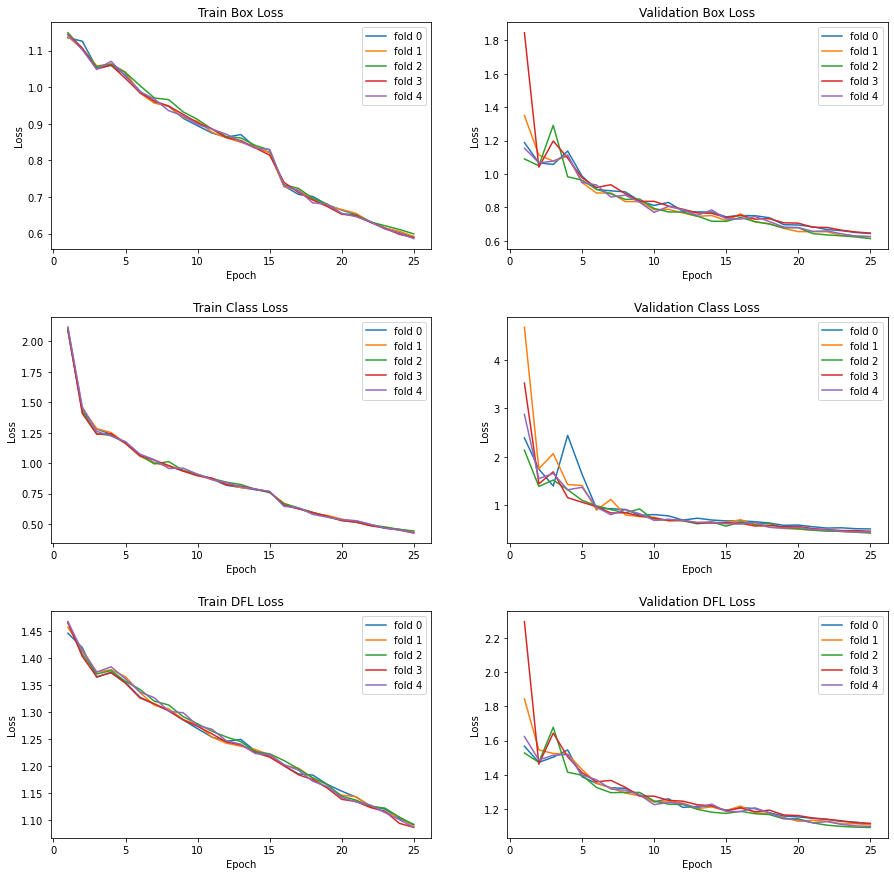

In [ ]:
df_all = pd.concat(all_results, ignore_index=True)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3)

metrics = [
    ('train/box_loss', 'Train Box Loss'),
    ('val/box_loss', 'Validation Box Loss'),
    ('train/cls_loss', 'Train Class Loss'),
    ('val/cls_loss', 'Validation Class Loss'),
    ('train/dfl_loss', 'Train DFL Loss'),
    ('val/dfl_loss', 'Validation DFL Loss')
]

for ax, (metric_col, metric_name) in zip(axes.flat, metrics):
    for f_id in range(k_folds):
        df_fold = df_all[df_all["fold"] == f_id]
        ax.plot(df_fold['epoch'], df_fold[metric_col], label=f'fold {f_id}')
    ax.set_title(metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

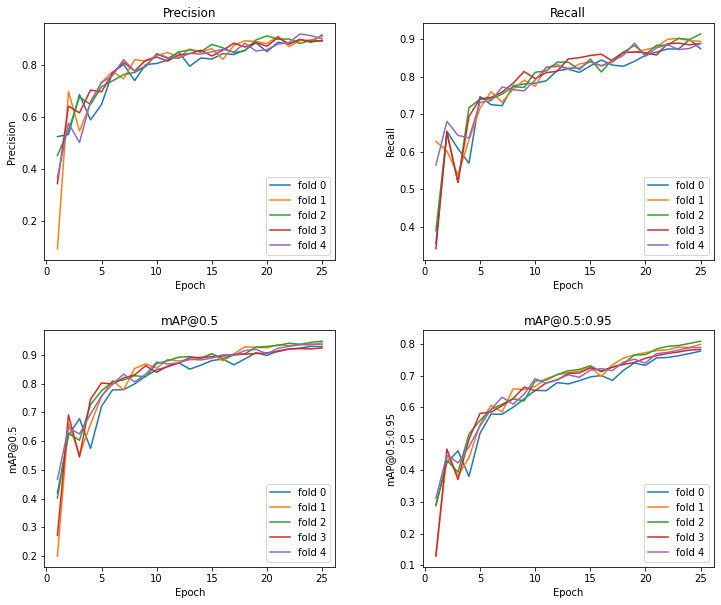

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

fig.subplots_adjust(hspace=0.3, wspace=0.3)

metrics = [
    ('metrics/precision(B)',   'Precision'),
    ('metrics/recall(B)',      'Recall'),
    ('metrics/mAP50(B)',       'mAP@0.5'),
    ('metrics/mAP50-95(B)',    'mAP@0.5:0.95')
]

for ax, (metric_col, metric_title) in zip(axes.flat, metrics):
    for fold_id in sorted(df_all['fold'].unique()):
        df_fold = df_all[df_all['fold'] == fold_id]
        ax.plot(df_fold['epoch'], df_fold[metric_col], label=f'fold {fold_id}')
    ax.set_title(metric_title)
    ax.set_ylabel(metric_title)
    ax.set_xlabel('Epoch')
    ax.legend()

plt.show()